# Data Investigation - Weather Data

### Import Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import seaborn as sns
sns.set()

In [2]:
print('Loading Weather Data...')

try:
    file_path_slug = '../../datasets/bayareabikeshare/*_weather_data.csv'
    
    # glob all files
    file_list = glob(file_path_slug)
    
    weather_import = pd.DataFrame()
    
    counter = 1
    chunks = []
    
    # load data from each file
    for file in file_list:
        
        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):
                        
            # define Columns
            chunk.columns = ['Date', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF', 'Max_Dew_Point_F', 
                             'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
                             'Max_Sea_Level_Pressure_In', 'Mean_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In', 
                             'Max_Visibility_Miles', 'Mean_Visibility_Miles', 'Min_Visibility_Miles', 
                             'Max_Wind_Speed_MPH', 'Mean_Wind_Speed_MPH', 'Max_Gust_Speed_MPH', 'Precipitation_In', 
                             'Cloud_Cover', 'Events', 'Wind_Dir_Degrees', 'zip']

            # append chunk to chunks list
            chunks.append(chunk)
        
        print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1
    
    # concat chunks
    weather_import = pd.concat(chunks)
    
    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')

Loading Weather Data...
	Finished file! (1 of 4)
	Finished file! (2 of 4)
	Finished file! (3 of 4)
	Finished file! (4 of 4)
Data Loaded Successfully!


In [3]:
weather_data = weather_import.copy()
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5495 entries, 0 to 1824
Data columns (total 24 columns):
Date                          5495 non-null object
Max_Temperature_F             5491 non-null float64
Mean_Temperature_F            5491 non-null float64
Min_TemperatureF              5491 non-null float64
Max_Dew_Point_F               5441 non-null float64
MeanDew_Point_F               5441 non-null float64
Min_Dewpoint_F                5441 non-null float64
Max_Humidity                  5441 non-null float64
Mean_Humidity                 5441 non-null float64
Min_Humidity                  5441 non-null float64
Max_Sea_Level_Pressure_In     5494 non-null float64
Mean_Sea_Level_Pressure_In    5494 non-null float64
Min_Sea_Level_Pressure_In     5494 non-null float64
Max_Visibility_Miles          5473 non-null float64
Mean_Visibility_Miles         5473 non-null float64
Min_Visibility_Miles          5473 non-null float64
Max_Wind_Speed_MPH            5494 non-null float64
Mean_Wind_

### Clean Data

In [4]:
print('Weather Data Cleanup Started...')

# cleanup column names
print('\tcleaning column names')
new_cols = []
for col in weather_data.columns:
    new_cols.append(col.replace(' ', '_').lower())
weather_data.columns = new_cols

# convert end and start dates to datetime objects
print('\tconverting dates to datetime objects')
weather_data['date'] = pd.to_datetime(weather_data['date'], format="%m/%d/%Y")

# extract columns we want to keep
print('\tsubsetting to useful columns')
important_cols = ['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperaturef',
                  'max_dew_point_f', 'meandew_point_f', 'min_dewpoint_f',
                  'max_wind_speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
                  'precipitation_in', 'cloud_cover', 'events', 'zip']
weather_data = weather_data[important_cols]

# correct min_temperaturef column name to min_temperature_f
# weather['min_temperaturef'].rename('min_temperature_f')
weather_data.rename(columns={'min_temperaturef': 'min_temperature_f'}, inplace=True)

# cleanup and set date as index
weather_data.set_index('date', inplace=True)
weather_data.sort_index(inplace=True)

# cleanup precipitation data to be all float values
weather_data['precipitation_in'] = pd.to_numeric(weather_data['precipitation_in'], errors='coerce')

print('Weather Data Cleanup complete')
weather_clean = weather_data.copy()

Weather Data Cleanup Started...
	cleaning column names
	converting dates to datetime objects
	subsetting to useful columns
Weather Data Cleanup complete


### Prune Data - San Francisco only

pruning weather data to only San Francisco data
	pruned data set 'weather_sf' consists of 1099 entries


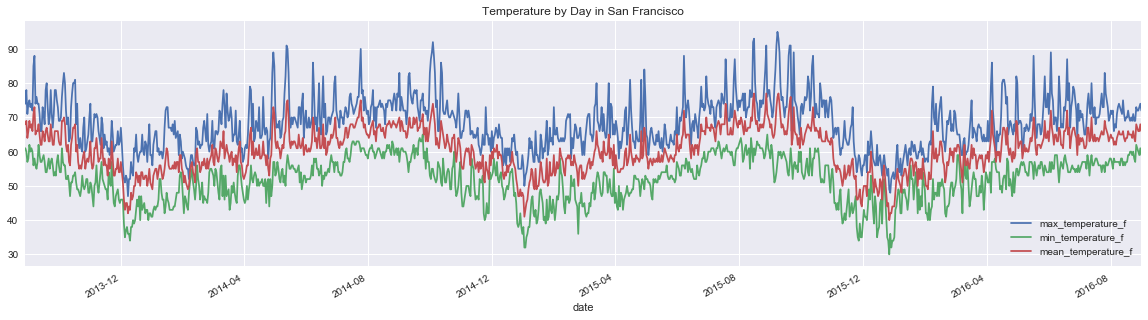

In [5]:
# prune weather data to only San Francisco data
print('pruning weather data to only San Francisco data')
weather_sf = weather_clean[weather_clean['zip'] == 94107].copy()


# Cleanup
weather_sf.sort_index(inplace=True)
print('\tpruned data set \'weather_sf\' consists of %i entries' % len(weather_sf.index))


# note the one day with a min temperature of zero
# that has not happened in San Francisco since 1932, so this can be ignored
weather_sf = weather_sf[weather_sf['min_temperature_f'] > 5.0]


# plot temperatures for San Francisco
weather_sf[['max_temperature_f', 'min_temperature_f', 'mean_temperature_f']].plot(figsize=(20,5))
plt.title('Temperature by Day in San Francisco')
plt.xlabel='Date'
plt.ylabel='Temperature (F)'
plt.legend(loc='best')
plt.show()

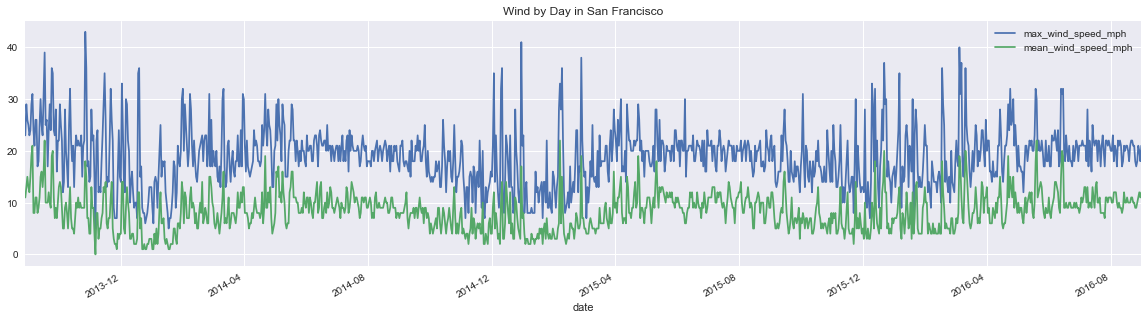

In [6]:
# plot temperatures for San Francisco
weather_sf[['max_wind_speed_mph', 'mean_wind_speed_mph']].plot(figsize=(20,5))
plt.title('Wind by Day in San Francisco')
plt.xlabel='Date'
plt.ylabel='Wind Speed (MPH)'
plt.legend(loc='best')
plt.show()

## Weather patterns that might effect Ridership

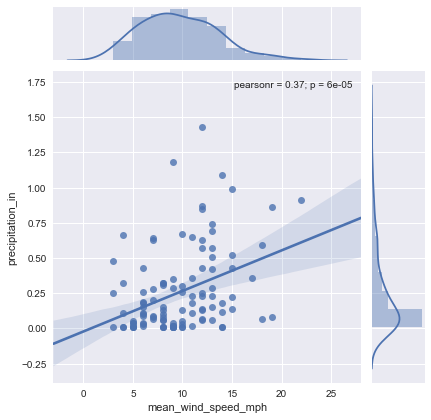

In [7]:
# compare windy and rainy days for correlation
weather_sf_rainy = weather_sf[weather_sf['precipitation_in'] < 3.0]
weather_sf_rainy = weather_sf_rainy[weather_sf_rainy['precipitation_in'] > 0.0]

# throw out outlier of rainiest day
sns.jointplot('mean_wind_speed_mph', 'precipitation_in', data=weather_sf_rainy, kind='reg')
plt.show()

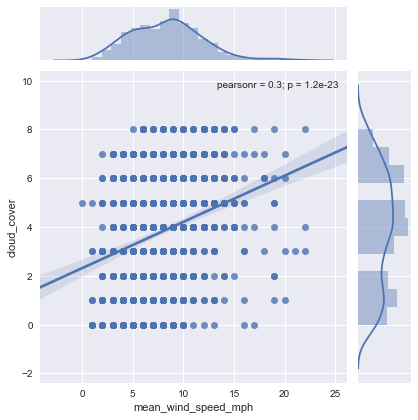

In [8]:
# compare windy and cloudy days for correlation
# throw out outlier of rainiest day
sns.jointplot('mean_wind_speed_mph', 'cloud_cover', data=weather_sf, kind='reg')
plt.show()

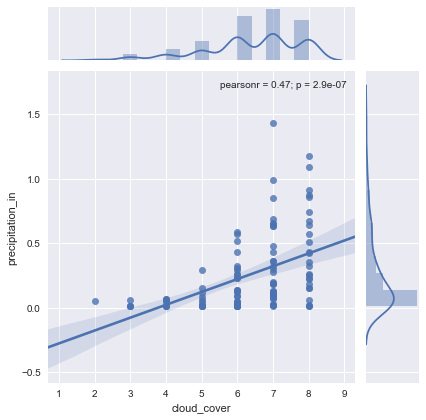

In [9]:
# compare cloudy and rainy days for correlation
sns.jointplot('cloud_cover', 'precipitation_in', data=weather_sf_rainy, kind='reg')
plt.show()

### Weather Take aways

> Precipitation is correlated to Cloud Cover
> 
> Mean Wind speed is correlated to Cloud Cover
>
> 